In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
import config

/var/folders/nb/4_pl8_150zg5d5snzc5tg0mm0000gn/T/ipykernel_38355/3060885761.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4419.)
  plt.imshow((psf0**1).T, origin="lower", cmap="viridis")


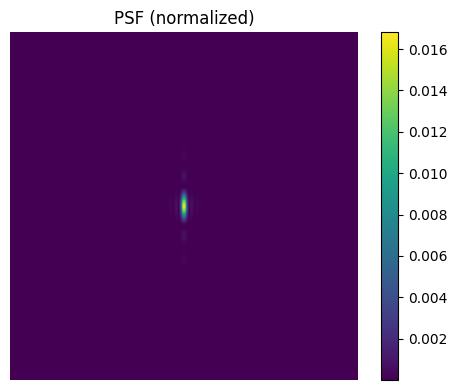

In [2]:
asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    init="hyperbolic",
    X=asm.X,
    Y=asm.Y,    
    test_orientation=True,
)

with torch.no_grad():
    psf, Uz = asm(phase_mask=phase, normalize=True, return_field=True)

psf0 = psf.detach().cpu()

plt.figure(figsize=(5, 4))
plt.imshow((psf0**1).T, origin="lower", cmap="viridis")
plt.title("PSF (normalized)")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()


Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


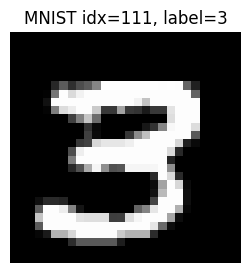

In [3]:
import torch
from torchvision.datasets import MNIST

# Load MNIST from your existing ./data folder (no download)
ds = MNIST(root="./data", train=True, download=False)

# Choose how many images to batch
N_batch = 10
idx0 = 111   # starting index

# Stack N_batch images into a batch
objs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

objs = torch.stack(objs, dim=0)   # [N,28,28]

print("Loaded batch:", objs.shape)
print("Labels (first 10):", labels[:10])

# Show ONE image from the batch
show_idx = 0
plt.figure(figsize=(3,3))
plt.imshow(objs[show_idx], cmap="gray", vmin=0, vmax=1)
plt.title(f"MNIST idx={idx0+show_idx}, label={labels[show_idx]}")
plt.axis("off")
plt.show()


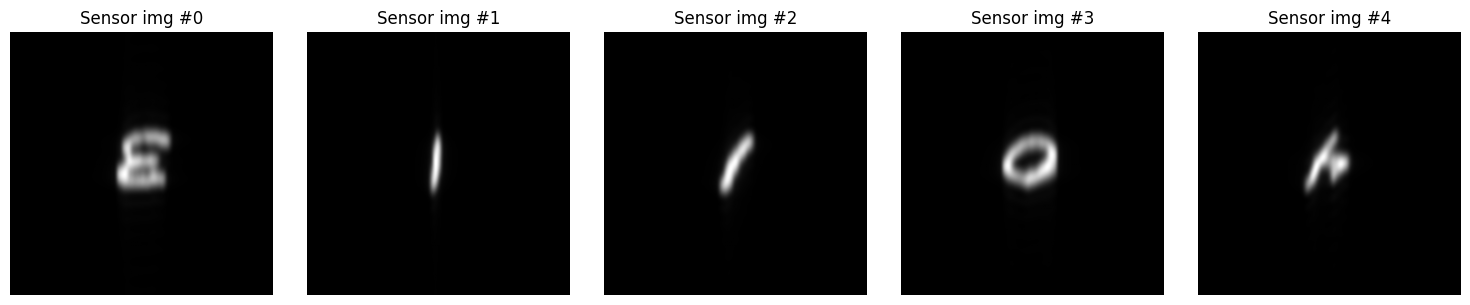

In [4]:
pm = PixelMap(config, asm.X, asm.Y)

conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psf)

num_show = min(5, imgs.shape[0])

fig, axs = plt.subplots(1, num_show, figsize=(3*num_show, 3))

for i in range(num_show):
    axs[i].imshow(
        imgs[i, 0].T.detach().cpu(),
        origin="lower",
        cmap="gray"
    )
    axs[i].set_title(f"Sensor img #{i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

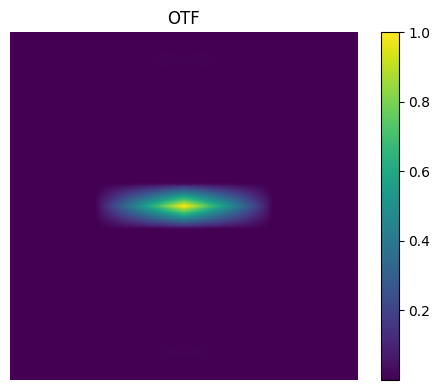

In [5]:
otf = conv.make_otfs(psf)
otf0 = torch.fft.fftshift(otf)

otf0 = otf0.detach().cpu()

# Magnitude (MTF) and phase
mag = torch.abs(otf0)
phase = torch.angle(otf0)

plt.figure(figsize=(5, 4))
plt.imshow((mag**1).T, origin="lower", cmap="viridis")
plt.title("OTF")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
phase = PhaseMask(
    config,
    num_masks=16,
    init="hyperbolic",
    defocus_max=20e-6,
    X=asm.X,
    Y=asm.Y,    
    # test_orientation=True,
)

with torch.no_grad():
    psfs, Uz = asm(phase_mask=phase, normalize=True, return_field=True)

print(Uz.shape)
print(psfs.shape)

torch.Size([16, 255, 255])
torch.Size([16, 255, 255])


In [13]:
pm = PixelMap(config, asm.X, asm.Y)

conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psfs)

print(imgs.shape)


torch.Size([10, 16, 255, 255])


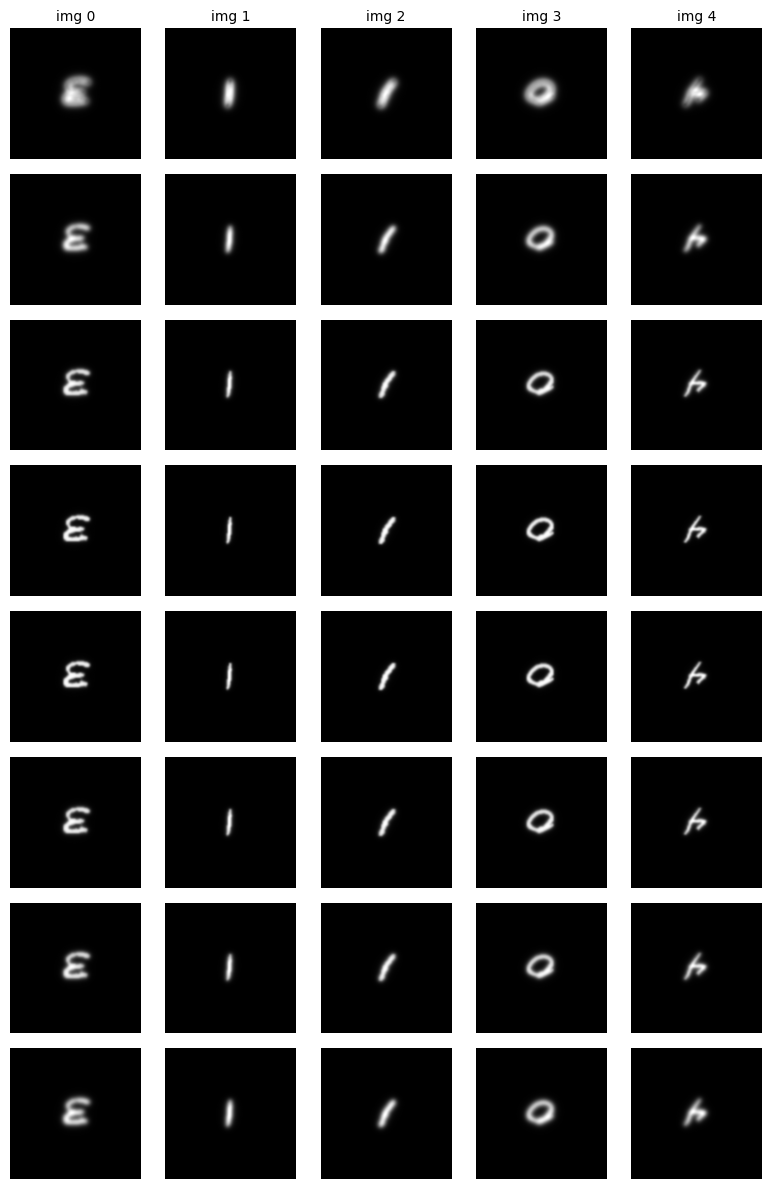

In [15]:
channels = [0, 2, 4, 6, 9, 11, 13, 15]  # every other channel -> 8
batch_idxs = list(range(5))        # first 5 images

fig, axes = plt.subplots(
    nrows=len(channels),
    ncols=len(batch_idxs),
    figsize=(8, 12),
    sharex=True,
    sharey=True
)

for r, ch in enumerate(channels):
    for c, b in enumerate(batch_idxs):
        ax = axes[r, c]
        ax.imshow(
            imgs[b, ch].T.detach().cpu(),
            cmap="gray",
            origin="lower"
        )
        ax.axis("off")

        if r == 0:
            ax.set_title(f"img {b}", fontsize=10)
        if c == 0:
            ax.set_ylabel(f"ch {ch}", fontsize=10)

plt.tight_layout()
plt.show()